# Setup Segmentation Model

In [1]:
import tensorflow as tf
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [2]:
IMG_DIM    =   128# @param
NB_CHANNEL =    1# @param

# Model Definition

In [3]:
WEIGHT_PATH=os.path.join(os.getcwd(),'weights','modifier.h5')
backbone= "efficientnetb7"# @param
model = sm.Unet(backbone,
              input_shape=(IMG_DIM,IMG_DIM,NB_CHANNEL), 
              classes=NB_CHANNEL,
              encoder_weights=None)
model.load_weights(WEIGHT_PATH)

# Imports and Helpers 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pytesseract
%matplotlib inline

def stripPads(arr,val):
    '''
        strip specific value
        args:
            arr :   the numpy array (2d)
            val :   the value to strip
        returns:
            the clean array
    '''
    # x-axis
    arr=arr[~np.all(arr == val, axis=1)]
    # y-axis
    arr=arr[:, ~np.all(arr == val, axis=0)]
    return arr

def invert_img(img):
    '''
        inverts an img
    '''
    img=img/255.0
    img=1-img
    img=img*255
    img=img.astype('uint8')
    return img
    

kernel=np.ones((5,5),np.uint8)
def get_sorted_values_of_parts(parts,num_parts):
    '''
        sorts values from left to right in a labeled image
        args:
            parts     =  labeled data
            num_parts =  number of parts present
        returns:
            list of values
    '''
    values=[]
    # create a copy
    data=np.copy(parts)
    for _ in range(num_parts):
        # non zeros
        x,y=np.where(data>0)
        y,x= zip(*sorted(zip(list(y), list(x))))
        # value
        v=parts[x[0],y[0]]
        # clean up
        data[data==v]=0
        # append
        values.append(v)
    return values

def padImage(img):
    '''
        pads an image and resizes
    '''
    # pad updown
    h,w=img.shape
    d1=(IMG_DIM-h)//2
    d2=IMG_DIM-d1-h
    top_bottom_pad1=np.ones((d1,w))*255
    top_bottom_pad2=np.ones((d2,w))*255
    img=np.concatenate([top_bottom_pad1,img,top_bottom_pad2],axis=0)
    img=img.astype('uint8')
    return img



# Image 

input image:





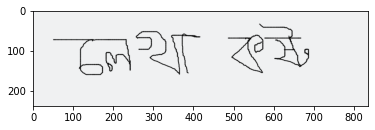

In [21]:
img_path=os.path.join(os.getcwd(),'4.png')
print('input image:\n\n\n')
img=cv2.imread(img_path)
plt.imshow(img)
plt.show()


# Single Grapheme Model

processing image
connecting words


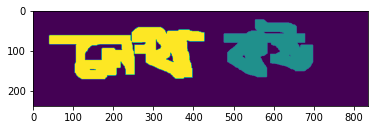

dividing data
grapheme processing


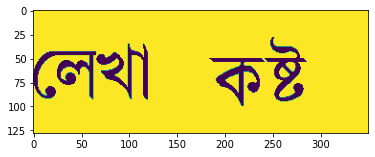

In [22]:
# process image
print("processing image")
img=cv2.imread(img_path,0)
blur = cv2.GaussianBlur(img,(5,5),0)
_,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img=invert_img(img)
# connect words
print("connecting words")
words=cv2.dilate(img,kernel,iterations=10)
words,num_of_words =scipy.ndimage.measurements.label(words)
plt.imshow(words)
plt.show()
# divide data
print("dividing data")
vals=get_sorted_values_of_parts(words,num_of_words)
data=[]
for component in vals:
    idx = np.where(words==component)
    y,h,x,w = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
    word = img[y:h, x:w]    
    graphemes,num=scipy.ndimage.measurements.label(word)
    _vals=get_sorted_values_of_parts(graphemes,num)
    wdata=[]
    for _val in _vals:
        grapheme=np.zeros(graphemes.shape)
        x,y = np.where(graphemes==_val)
        grapheme[x,y]=255
        grapheme=stripPads(grapheme,0)
        h,w=grapheme.shape
        if h>20 and w>20:
            wdata.append(grapheme)
    data.append(wdata)
# grapheme processing
print("grapheme processing")
# pad
pad=np.ones((IMG_DIM,IMG_DIM//2))*255
pad=pad.astype('uint8')
kernel=np.ones((3,3),np.uint8)
comp=[]
for word in data:
    x=[]
    for grapheme in word:
        grapheme=cv2.dilate(grapheme,kernel,iterations=1)    
        grapheme=invert_img(grapheme)
        grapheme=cv2.resize(grapheme,(IMG_DIM,IMG_DIM))
        blur = cv2.GaussianBlur(grapheme,(5,5),0)
        _,grapheme = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        grapheme=np.expand_dims(grapheme,axis=-1)
        grapheme=np.expand_dims(grapheme,axis=0)
        x.append(grapheme)
    x=np.vstack(x)
    x=x/255.0
    
    y=model.predict(x)
    text=''
    ds=[]
    for d in y:
        d=np.squeeze(d)
        d=d*255
        d=d.astype('uint8')
        blur = cv2.GaussianBlur(d,(5,5),0)
        _,d = cv2.threshold(d,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ds.append(d)
        
    d=np.concatenate(ds,axis=1)
    d=stripPads(d,255)
    d=padImage(d)
    comp.append(d)
    comp.append(pad)

final=np.concatenate(comp,axis=1) 
blur = cv2.GaussianBlur(final,(5,5),0)
_,final = cv2.threshold(final,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
plt.imshow(final)
plt.show()
    
    
    
        


In [23]:
pred = pytesseract.image_to_string(final, lang='ben', config='--psm 6')
text=pred.replace('\n','')
print("image text:\n\n\n")
print(text)
print("\n\n\n")


image text:



লেখা কষ্টু






In [ ]:
EXAMPLE OF FALSE PREDICTIONS

In [ ]:
ALTHOUGH IT LOOKS CORRECTED BUT ITS WRONG

In [ ]:
ERRORS HAPPEING AT TWO STAGES:
    * Modifier Model Stage
    * Tesseract it self is flawed
    
THANK YOU